In [35]:
import spacy
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import naive_bayes, svm, metrics
import pandas as pd
# reset colwitdth options when running all cells 
pd.reset_option('display.max_colwidth')

#### Load dataset and group by day (all tweets and corresponding stock prices)

In [36]:
data = pd.read_json('processed_data/data_merged.json')
# remove columns that were unexpectedly generated during saving
# data.drop(columns=['level_0', 'index'], inplace=True)
data.tail(3)

,timestamp,hashtags,text,username,likes,replies,retweets,Open,Close,PriceUp
4946,2018-06-04,"[Tesla, Model3pic]",Report: Tesla Has Refunded 23% of Model 3 Depo...,Tesla Motors Club,91,13,13,294.34,296.74,True
4947,2018-06-04,"[Tesla, NikolaTeslapic]",Make electricity free again! #Tesla #NikolaTes...,Mr A 🎶🎵 ♏,2,1,1,294.34,296.74,True
4948,2018-06-04,"[Tesla, ElonMusk, CFD, forex, equitypic]",#Tesla #ElonMusk #CFD #forex #equitypic.twitte...,The Utkarsh,2,1,1,294.34,296.74,True


In [37]:
# group data by day
daily_data = data.groupby(data['timestamp'], as_index=False)
daily_data.first()

,timestamp,hashtags,text,username,likes,replies,retweets,Open,Close,PriceUp
0,2018-01-02,"[Tesla, ModelS]","In the past 2 years, I've driven 18,823 miles ...",Ben Sullins 💪,110,6,10,312.00,320.53,True
1,2018-01-03,[Tesla],Día de piernas ... Estrenando mallas...#Tesla ...,El CaZador,107,3,4,321.00,317.25,False
2,2018-01-04,"[Innovation, Tesla, electricvehicles, Cars, br...",This is awesome! New brand technology #Innovat...,Gabriela Mascaró,6,1,3,312.87,314.62,True
3,2018-01-05,"[Tesla, TeslaModel3]",#Tesla #TeslaModel3 hahapic.twitter.com/DMlxOf...,WtaFiGO,19,1,7,316.62,316.58,False
4,2018-01-08,[Tesla],Tesla Planning Supercharger Station With ‘Old ...,Tesla Motors Club,132,4,16,316.00,336.41,True
...,...,...,...,...,...,...,...,...,...,...
98,2018-05-29,"[Tesla, Elektroautopic]","#Tesla Model 3: Europa-Start ""erste Jahreshälf...",ecomento.de,3,2,1,278.51,283.76,True
99,2018-05-30,[Tesla],Oh well... in case you were wondering why @Tes...,Safer Vehicles Proved,27,4,9,283.29,291.72,True
100,2018-05-31,[Tesla],Take comfort #Tesla friends. All the alleged ...,Groggy T. Bear,22,4,3,287.21,284.73,False
101,2018-06-01,"[FBI, Tesla]",Según documento desclasificado del #FBI Niko...,Misterio Desconocido,40,3,14,285.86,291.82,True


In [38]:
# count tweets per day to see if they're ok'ish distributed
tweets_per_day = daily_data['text'].count()
tweets_per_day.describe()

,text
count,103.000000
mean,48.048544
std,34.304970
min,6.000000
25%,34.500000
50%,40.000000
75%,51.000000
max,266.000000


We have in average almost 50 tweets per day with a minimum of 6 tweets, which should be ok. The standard deviation is quite high too, but since we're so far only looking at individual tweets, this is absolutely ok. Even when we go for averaging the tweets of a single day, it should still be fine.

In [39]:
# get groups' names
daily_data.groups.keys()
groups = [name for name, _ in daily_data]
groups[0]

Timestamp('2018-01-02 00:00:00')

In [40]:
# get all tweets from the first day
first_day_data = daily_data.get_group(groups[0])
first_day_data.head()

,timestamp,hashtags,text,username,likes,replies,retweets,Open,Close,PriceUp
0,2018-01-02,"[Tesla, ModelS]","In the past 2 years, I've driven 18,823 miles ...",Ben Sullins 💪,110,6,10,312.0,320.53,True
1,2018-01-02,"[Tesla, P90D, Blog, Youtube]",Ya estamos en @louesfera probando un #Tesla #P...,Fco Javier,2,1,2,312.0,320.53,True
2,2018-01-02,"[Snapchat, Uber, Twitter, Facebook, Tesla, Goo...",Here's how old these companies will be turning...,Imran,53,7,41,312.0,320.53,True
3,2018-01-02,[Muskwatchpic],"From SpaceX to Tesla, here are our biggest que...",Nerdist,37,5,10,312.0,320.53,True
4,2018-01-02,"[Braunschweig, VW, Tesla]",In #Braunschweig produziert #VW seine Batterie...,HAZ,5,3,2,312.0,320.53,True


## A first very simple classifier using Word Vectors from spacy
Use each tweet and predict whether it was written on a day where stock price has grown (PriceUp == True) or not



In [41]:
try:
    nlp = spacy.load("en_core_web_md")
except:
    import en_core_web_sm
    nlp = en_core_web_sm.load()
    
tweet_vectors = []

# Vectorize each tweet
for tweet in data.text:
    tokens = nlp(tweet)
    average_token= tokens[0].vector
    summed_token_count = 1
    for token in tokens[1:]:
        # Only add to our sentence average token is token is not a stop word or if it's a negation
        if token.dep_ == 'neg' or not token.is_stop:
            average_token = average_token + token.vector
            summed_token_count += 1
    average_token = average_token / summed_token_count
    tweet_vectors.append(average_token)


In [42]:
# generate the train and test sets
tweets_train, tweets_test, labels_train, labels_test = train_test_split(tweet_vectors, data['PriceUp'], 
                                                   test_size=0.2, random_state=333, shuffle=True)
len(tweets_train)

3959

### Continue here...
Vectorize the data... create a train and test matrix using word vectors from spacy... check if classifiers overfit to the training data... then evaluate on test data using the code below

In [43]:
print(len(tweets_train),len(labels_train))
print(len(tweets_test),len(labels_test))
print(type(tweets_train[0]))
print(np.shape(tweets_train[0]))
print("One vector: ", tweets_train[2])

3959 3959
990 990
<class 'numpy.ndarray'>
(300,)
One vector:  [-0.12318653  0.31284353  0.09677783 -0.02063794  0.0247953  -0.04264142
  0.1881359  -0.08098528 -0.0778923   0.814553   -0.08372599 -0.001502
 -0.0430963   0.07591461 -0.09694488 -0.0519827  -0.0389587   0.91624004
 -0.01284453 -0.01406124  0.10105217  0.14758664 -0.05296901 -0.03626784
  0.03632429  0.02446806  0.06302512 -0.09648801  0.0912114   0.13096687
 -0.09319735  0.08387847 -0.04377272 -0.0755683  -0.03314523 -0.026087
  0.06871071  0.23640902 -0.03469265  0.11739431 -0.06870618  0.03907594
  0.07549335  0.00370218  0.06463748  0.1767252  -0.14010529  0.10030553
 -0.10516535  0.00386688  0.12673846  0.1554393  -0.09629241 -0.13910389
  0.06916359  0.12379146  0.17866823  0.09073476  0.09982307  0.02039159
 -0.19406684 -0.03612772 -0.08571248  0.08951347 -0.01695798 -0.09931818
 -0.03783483  0.16976954 -0.09517317  0.03395747  0.11366353 -0.07791886
  0.08646     0.06813677  0.06057964  0.08525971  0.03355547 -0.14

### Train and Test classifiers

In [44]:
print(type(tweets_train))
print(type(labels_train))

<class 'list'>
<class 'pandas.core.series.Series'>


In [45]:
# increase number of training examples (by repeating them n times)
n = 2
train_matrix_n_times = tweets_train*n
labels_train_n_times = pd.concat([labels_train]*n, ignore_index=True)

In [46]:
svm_classifier = svm.LinearSVC(max_iter=int(1e6))
svm_classifier.fit(train_matrix_n_times, labels_train_n_times)

nb_classifier = naive_bayes.GaussianNB()
nb_classifier.fit(train_matrix_n_times, labels_train_n_times)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Test if training was successful
As we have not enough data, a working classifier should overfit to the training data and hence perfectly predict the labels of the training set.

In [47]:
# check if classifier has really overfitted to the data by testing it on the training data
preds_svm = svm_classifier.predict(tweets_train)
svm_acc = metrics.accuracy_score(labels_train, preds_svm)

preds_nb = nb_classifier.predict(tweets_train)
nb_acc = metrics.accuracy_score(labels_train, preds_nb)


svm_prec, svm_rec, svm_fscore, svm_sup = \
metrics.precision_recall_fscore_support(labels_train, preds_svm, pos_label=True, average='binary')

nb_prec, nb_rec, nb_fscore, nb_sup = \
metrics.precision_recall_fscore_support(labels_train, preds_nb, pos_label=True, average='binary')

print('   \t\tSVM \t\tNaive Bayes')
print('Acc \t\t {0:.3f} \t\t {1:.3f}'.format(svm_acc, nb_acc))
print('Prec \t\t {0:.3f} \t\t {1:.3f}'.format(svm_prec, nb_prec))
print('Rec \t\t {0:.3f} \t\t {1:.3f}'.format(svm_rec, nb_rec))
print('FMeas \t\t {0:.3f} \t\t {1:.3f}'.format(svm_fscore, nb_fscore))

SVM 		Naive Bayes
Acc 		 0.640 		 0.551
Prec 		 0.645 		 0.587
Rec 		 0.703 		 0.495
FMeas 		 0.673 		 0.537


# Observations:
Both classifiers reached quite poor performance when evaluating on even the training set. This could mean, we have no overfitting and have a hope for getting a bit generalization, but we believe there are other problems that can explain this observation: 
* das Language Model wurde auf anderen Daten trainiert... Die Dimensionen der Vektoren haben alle eine für unsere Aufgabe irrelevante Bedeutung.
* Durschnitt eines Tweets verliert seine Bedeutung komplett 

In [48]:
# test the classifiers
preds_svm = svm_classifier.predict(tweets_test)
svm_acc = metrics.accuracy_score(labels_test, preds_svm)

preds_nb = nb_classifier.predict(tweets_test)
nb_acc = metrics.accuracy_score(labels_test, preds_nb)


svm_prec, svm_rec, svm_fscore, svm_sup = \
metrics.precision_recall_fscore_support(labels_test, preds_svm, pos_label=True, average='binary')

nb_prec, nb_rec, nb_fscore, nb_sup = \
metrics.precision_recall_fscore_support(labels_test, preds_nb, pos_label=True, average='binary')

print('   \t\tSVM \t\tNaive Bayes')
print('Acc \t\t {0:.3f} \t\t {1:.3f}'.format(svm_acc, nb_acc))
print('Prec \t\t {0:.3f} \t\t {1:.3f}'.format(svm_prec, nb_prec))
print('Rec \t\t {0:.3f} \t\t {1:.3f}'.format(svm_rec, nb_rec))
print('FMeas \t\t {0:.3f} \t\t {1:.3f}'.format(svm_fscore, nb_fscore))

SVM 		Naive Bayes
Acc 		 0.558 		 0.503
Prec 		 0.569 		 0.529
Rec 		 0.627 		 0.439
FMeas 		 0.597 		 0.480


To make a statement about the results, we first have to look at the distribution of labels in the test dataset.
An even simpler baseline we can use is a classifier that constantly predicts the class that is most common in the test set. 

In [49]:
num_trues, num_falses = labels_test.value_counts()
print("A classifier that always predicts 'True' would get an accuracy of: %.3f" % (num_trues/labels_test.count()))

A classifier that always predicts 'True' would get an accuracy of: 0.522


## Stock Market Simulation:


Use our classifier with the simulation tool

[0, 0, 0, 0, 1, -1, 0, 1, 0, 0, -1, -1, 0, -1, 0, -1, -1, 1, 0, 0, 0, -1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0, -1, -1, 0, 1, -1, 0, -1, -1, -1, -1, 0, -1, 0, 1, 0, -1, -1, -1, -1, 0, -1, 0, 0, -1, -1, -1, 0, 1, 0, 1, -1, 0, 0, 1, 0, -1, 1, 0, -1, -1, 0, 0, -1, -1, -1, -1, 0, -1, -1, -1, 1, 1, 0, 0]
106
106
[0, 0, 0, 0, 1, -1, 0, 1, 0, 0, -1, -1, 0, -1, 0, -1, -1, 1, 0, 0, 0, -1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0, -1, -1, 0, 1, -1, 0, -1, -1, -1, -1, 0, -1, 0, 1, 0, -1, -1, -1, -1, 0, -1, 0, 0, -1, -1, -1, 0, 1, 0, 1, -1, 0, 0, 1, 0, -1, 1, 0, -1, -1, 0, 0, -1, -1, -1, -1, 0, -1, -1, -1, 1, 1, 0, 0]
[0, 0, 0, 0, 1, -1, 0, 1, 0, 0, -1, -1, 0, -1, 0, -1, -1, 1, 0, 0, 0, -1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, -1, 0, 0, 0, 0, 0, -1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0, -1, -1, 0, 1, -1, 0, -1, -1, -1, -1, 0, -1, 0, 1, 0, -1, -1, -1, -1, 0, -1, 0, 0, -1, -1, -1, 0, 1, 0, 1, -1, 0, 

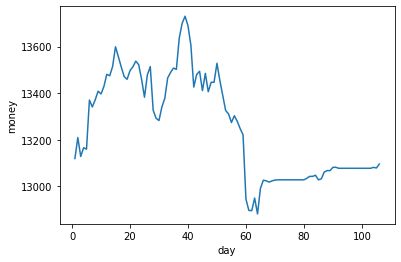

In [63]:
from stock_market_simulation import load_stock_prices_from_json, Trader

stock_prices = load_stock_prices_from_json()


# Impact of the tweet of the classification of each tweet result
data['impact'] = data.likes + data.replies + data.retweets
# Recommendation obtained by the classifier
data['recommendation'] = svm_classifier.predict(tweet_vectors)

# Decide on the action of the day, based on the recommendations per tweet weighted by their impact.
actions = []
for day, group in data.groupby(data['timestamp'], as_index=False):
     
    weighted_recommendation = 0
    for impact, recommendation in zip(group.impact, group.recommendation):
        if recommendation:
            weighted_recommendation += impact
        else:
            weighted_recommendation -= impact
    weighted_recommendation /= sum(group.impact)
    # Experiment with thresholds for the actions on the stock market
    actions.append([day, 1 if weighted_recommendation > 0.5 else -1 if weighted_recommendation < 0 else 0])

actions = pd.DataFrame(actions, columns=['day', 'action'])
actions = actions.set_index('day').resample('D').asfreq(fill_value=0)
actions = actions.loc[stock_prices.index]['action'].to_list()

print(actions)
print(len(stock_prices))
print(len(actions))

simulation = Trader(stock_prices, actions)
simulation.stock_action()


In [54]:
data

,timestamp,hashtags,text,username,likes,replies,retweets,Open,Close,PriceUp,impact,recomendations,recomendation
0,2018-01-02,"[Tesla, ModelS]","In the past 2 years, I've driven 18,823 miles ...",Ben Sullins 💪,110,6,10,312.00,320.53,True,126,False,False
1,2018-01-02,"[Tesla, P90D, Blog, Youtube]",Ya estamos en @louesfera probando un #Tesla #P...,Fco Javier,2,1,2,312.00,320.53,True,5,True,True
2,2018-01-02,"[Snapchat, Uber, Twitter, Facebook, Tesla, Goo...",Here's how old these companies will be turning...,Imran,53,7,41,312.00,320.53,True,101,False,False
3,2018-01-02,[Muskwatchpic],"From SpaceX to Tesla, here are our biggest que...",Nerdist,37,5,10,312.00,320.53,True,52,False,False
4,2018-01-02,"[Braunschweig, VW, Tesla]",In #Braunschweig produziert #VW seine Batterie...,HAZ,5,3,2,312.00,320.53,True,10,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4944,2018-06-04,"[Tesla_Insurance, Tesla_Model_S]",Best Rate On Tesla Auto Insurance? Prepare For...,InsideEVs,3,2,2,294.34,296.74,True,7,True,True
4945,2018-06-04,"[teslavoda, tesla, fiba3x3, limanteslavoda, ba...",Strong deffence @instazvonko .\n Chengdu Ch...,Liman 3x3,4,2,1,294.34,296.74,True,7,False,False
4946,2018-06-04,"[Tesla, Model3pic]",Report: Tesla Has Refunded 23% of Model 3 Depo...,Tesla Motors Club,91,13,13,294.34,296.74,True,117,True,True
4947,2018-06-04,"[Tesla, NikolaTeslapic]",Make electricity free again! #Tesla #NikolaTes...,Mr A 🎶🎵 ♏,2,1,1,294.34,296.74,True,4,True,True
